Most distributions in nature are too complex to be modeled by any one fundamental distribution. Mixture Models allow us to model these complex distributions while still utilizing the analytic simplicity of fundamental distributions. For example, the classic Old Faithful dataset is comprised of 272 measurements of eruptions of the Old Faithful Geyser in Yosemite. Each measurement is composed of the duration of the eruption and the time until the next eruption. A plot of it is shown below

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

In [2]:
import numpy as np
old_faithful_data = np.genfromtxt('old_faithful.csv', delimiter=',', names=True)
ofd = np.array([list(d) for d in old_faithful_data]) # vectorize it

<IPython.core.display.Javascript object>


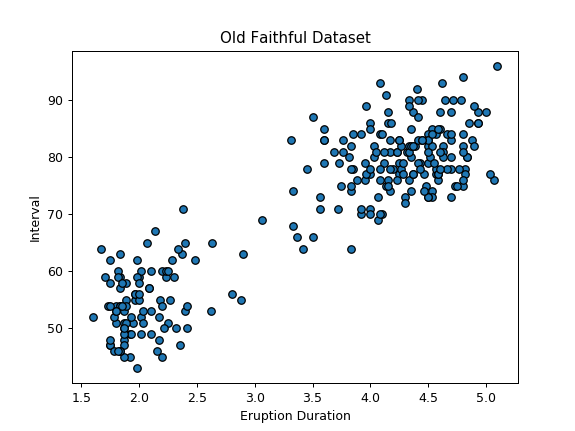

In [3]:
import matplotlib as mpl
mpl.use('nbagg')
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(ofd[:,1], ofd[:,2], edgecolor='k')
ax.set(xlabel='Eruption Duration', ylabel='Interval', title='Old Faithful Dataset')
plt.show()

We'd now like to fit a distribution to this data. What does it mean to fit a distribution to data? It means that given a particular family of parametric distributions we'd like to determine the parameters that maximize the probability of the data. In other words, if we know we'd like to find a Gaussian to describe our data, we try to find the particular mean and covariance that best describe the data. A graphical interpretation is, we'd like the distribution to have a high probability where the density of the data is high, and a low probability where the density of the data is low. 

A single Gaussian distribution would poorly represent the density in this dataset. We demonstrate this by fitting a single two dimensional Gaussian to it. Let's take a look at what happens when we fit one two dimensional Gaussian to the data.

In [4]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

<IPython.core.display.Javascript object>


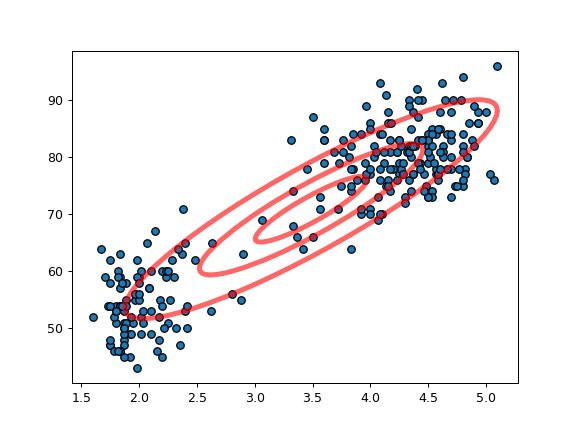

In [5]:
fig, ax = plt.subplots()
ax.scatter(ofd[:,1], ofd[:,2], edgecolor='k')
import matplotlib.patches as mpatches
from scipy import linalg
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture().fit(ofd[:,1:])
mu = gmm.means_[0]
w,v = linalg.eigh(gmm.covariances_[0])
w = 2*np.sqrt(2)*np.sqrt(w)
angle = np.arctan(v[0,1] / v[0,0])
for std in [0.3,0.6,1]:
    ellipse = mpatches.Ellipse(mu, std*w[0], std*w[1], angle*(180/np.pi), edgecolor='r', alpha=0.6, fill=False, lw=4)
    ax.add_patch(ellipse)
plt.show()

The Gaussian mean is pulled between the two clusters suggesting there is a high probability for eruptions where there is little data. This model will be of little use. In this contrived 2D scenario we can visually inspect the data and see that it is bimodal. This suggests that a bimodal distribution will better describe our data. Rather than dealing with complex families of bimodal distributions we can use a 2 mode Gaussian mixture model to fit this data. The results are shown below.

<IPython.core.display.Javascript object>


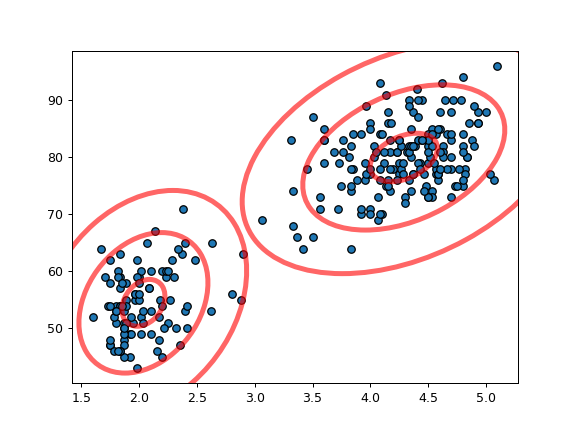

In [6]:
fig, ax = plt.subplots()
ax.scatter(ofd[:,1], ofd[:,2], edgecolor='k')
gmm = GaussianMixture(2).fit(ofd[:,1:])
for mu, cov in zip(gmm.means_,gmm.covariances_):
    w,v = linalg.eigh(cov)
    w = 2*np.sqrt(2)*np.sqrt(w)
    angle = np.arctan(v[0,1] / v[0,0])
    for std in [0.5,1.5,2.4]:
        ellipse = mpatches.Ellipse(mu, std*w[0], std*w[1], angle*(180/np.pi), edgecolor='r', alpha=0.6, fill=False, lw=4)
        ax.add_patch(ellipse)
plt.show()



Now that we've motivated a need for Mixture Models, let us take a step back and mathematically show their relationship to k-means and expectation maximization. For a more thorough exploration of clustering with Gaussian Mixture Models see Bishop [1]. 

### Shortest Into to k-means ever

The notion of a 'cluster' is intrinsically subjective. As a consequence there is no accepted academic definition of what clustering is. Though, a popular highlevel motivation for clustering, is the desire to find groups in high dimensional space.  Given a dataset of $N$ vectors in $D$ dimensional space $\{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N\}$ we would like to partition the dataset into $K$ clusters. We will represent each cluster by a centroid $\boldsymbol{\lambda}_k$ and define the clustering problem as simultaneously finding the assignment of data point $\mathbf{x}_i$ to cluster $j$ and finding the values of the cluster centroids $\boldsymbol{\lambda}_k$ that minimize some cost $J$. The k-means algorithm employs a cost function that suggests the solution to the clustering problem is found by minimizing the distance between each data point and its corresponding cluster's centroid. We will use the $1$-of-$K$ encoding scheme to represent this idea. A binary indicator variable $r_{nk}$ for each data point will be used. If data element $n$ has been assigned to cluster $k$, then $r_{nj} = 1$ when $j=k$ and $r_{nj} = 0$ for $j \ne k$. In other words each data point $\mathbf{x}_n$ has $K$ binary variables assigned to it, where only one of them has the value of $1$ indicating which cluster it belongs to. This notational convention provides a convenient means to express the loss function, also referred to as the $\textit{distortion measure}$.

$$J = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \left\lVert \mathbf{x}_n-\boldsymbol{\lambda}_k \right\rVert^2$$

This is a multivariate minimization problem. We'd like to find all the $\{r_{nk}\}$ and the $\{\lambda_k\}$ such that the cost is minimized. First we find the values of $r_{nk}$ by taking the partial derivative of $J$ with respect to $r_{nk}$ and setting it to zero. This yeilds the following equation

$$ r_{nk} = \begin{cases} 
      1 & \text{if } k=\mathrm{argmin}_j{\left\lVert \mathbf{x}_n-\boldsymbol{\lambda}_j \right\rVert^2} \\
      0 & \text{otherwise.}
   \end{cases}
$$

These results tell us that the cost with respect to $r_{nk}$ is minimized when we assign each data point $\mathbf{x}_n$ to its closest cluster centroid $\boldsymbol{\lambda}_k$.

Next we find the cluster centroids that minimize the cost. Setting the partial of the cost with respect to the cluster centroids to zero yeilds the following equation.

$$2\sum_{n=1}^N r_{nk}(\mathbf{x}_n-\boldsymbol{\lambda}_k)=0$$

If we solve for $\lambda_k$ we arrive at an expression that describes the optimal cluster centroids as the mean of the points $\{\mathbf{x}_n\}$ currently in cluster $k$.

$$\lambda_k = \frac{\sum_{n}r_{nk}\mathbf{x}_n}{\sum_n r_{nk}}$$

These two solutions bring us the well known two-pass algorithm, called k-means, for solving the clustering problem. First we take a set of initial cluster centroids ${\boldsymbol{\lambda}_k}$ and assign each data point to the cluster $k$ defined by its closest centroid. We then update the cluster centroids by defining them to be the new mean of the data points ${\mathbf{x}_n}$ in cluster $k$, hence the name $\textit{k-means}$. These two passes correspond respectively to the expectation and maximization steps of the Expecataion Maximization (EM) algorithm, which we will use to solve the Gaussian Mixture Model clustering problem.

### Shortest Into to clustering with Gaussian Mixture Models ever

The one dimensional Gaussian, or normal distribution, is defined as follows

$$\mathcal{N}(x \mid \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\text{exp}\bigg\{-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}\bigg\}$$

This can be generalized to $D$ dimensions and expressed using vector notation

$$\mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu},\boldsymbol{\Sigma}) = \frac{1}{\sqrt{(2\pi)^{D}|\boldsymbol{\Sigma}|}}\text{exp}\bigg\{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^\text{T}\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\bigg\}$$

Where $\boldsymbol{\mu}$ is the vector of means and $\boldsymbol{\Sigma}$ is the covariance matrix. 



$$p(x) = \sum\limits_{k=1}^{K}\pi_k \mathcal{N}(\mathbf{x} \mid \mathbf{\mu}_k,\mathbf{\Sigma}_k)$$

### References

[1] Nasrabadi, Nasser M. "Pattern recognition and machine learning." Journal of electronic imaging 16.4 (2007): 049901.